# Vizualizace ve strojovém učení

# Zpracování

In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

random_state = 420

## Výběr datasetu

> V tomto notebooku se bude používat dataset prodaných aut s jejich prodejní cenou a parametry vozidla. Půjde tedy o supervizovanou regresní úlohu a to z důvodu predikce prodejní ceny.

Finální model by mohl sloužit jako pomůcka při odhadování ceny právě při prodeji vozidla.

Odkaz na kaggle stránku datasetu je [zde](https://www.kaggle.com/datasets/deepcontractor/car-price-prediction-challenge) (případně je dataset k dispozici i ve formě csv souboru).

### Popis příznaků

- `ID` - identifikátor prodeje
- `Price` - vysvětlovaná proměnná (cena)
- `Levy` - daň z prodeje
- `Manufacturer` - výrobce
- `Model` - model auta
- `Prod. year` - rok výroby
- `Category` - typ vozidla
- `Leather interior` - kožený interiér 
- `Fuel type` - typ pohonné hmoty
- `Engine volume` - objem motoru
- `Mileage` - najeté kilometry
- `Cylinders` - počet válců
- `Gear box type` - typ převodovky
- `Drive wheels` - náhon kol
- `Doors` - počet dveří
- `Wheel` - umístění volantu
- `Color` - barva auta
- `Airbags` - počet airbagů

## Načtení datasetu
Načteme dataset z csv souboru, nahradíme prázdné hodnoty pomocí `np.nan` a jelikož se jedná o supervizované učení, tak odstraníme záznamy bez vysvětlované proměnné (pokud nějaké existují).

Následně data rozdělíme na *trénovací, validační a testovací* množiny. Explorační analýzu budeme provádět pouze na trénovacích a validačních datech z důvodu simulace nevědomosti struktury příchozích dat. Testovací data si ponecháme až pro ověření *"efektivity"* našeho modelu.

Navíc odstraníme příznak `ID`, který je nám v kontextu predikce k ničemu.

In [161]:
def delete_empty_target_rows(df, feature):
    """ Remove rows where selected feature is null """

    null_cnt = df[feature].isnull().sum()
    print(f'Removed {null_cnt} rows')
    
    df.drop(list(df[feature][df[feature].isnull()].index), axis=0, inplace=True)

Načteme tedy dataset a odstraníme řádky bez vysvětlované proměnné a sloupec `ID`. Navíc se ještě zbavíme případných duplicitních záznamů.

In [162]:
from sklearn.model_selection import train_test_split

# load dataset from csv and fill empty values with `np.nan`
dataset = pd.read_csv('car_prices.csv').fillna(np.nan)
target = 'Price'

# remove rows without target value
delete_empty_target_rows(dataset, target)

# remove ID column
dataset.drop(['ID'], axis=1, inplace=True)

# drop duplicates

prev_cnt = dataset.shape[0]
dataset.drop_duplicates(inplace=True)
post_cnt = dataset.shape[0]
print('Dropped duplicates:', prev_cnt - post_cnt)

Removed 0 rows
Dropped duplicates: 3512


Můžeme vidět, že záznamy bez vysvětlované proměnné žádné nebyly. Naopak duplikátů bylo odstraněno `3512`.

## Rozdělení na train, val, test
Rozdělíme data na 3 disjunktní množiny a EDA budeme provádět na sloučení trénovacích a validačních dat.

In [163]:
X = dataset.drop([target], axis=1)
y = dataset[target]

# train, test, val split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=random_state)
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.25, random_state=random_state)

# merge target feature back with X matrix
train, val, test = (
    pd.concat([Xtrain, ytrain], axis=1), 
    pd.concat([Xval, yval], axis=1),
    pd.concat([Xtest, ytest], axis=1)
)

# merge train and val back for EDA
data = pd.concat([train, val], axis=0)

print('Train:', train.shape)
print('Val:', val.shape)
print('Test:', test.shape)

Train: (9435, 17)
Val: (3145, 17)
Test: (3145, 17)


## Explorační analýza dat

In [164]:
# blue, orange color hex codes
BLUE, ORANGE = '#3274A1', '#E1812C'

### Základní informace
Zobrazíme základní strukturu dat a jejich typy.

In [165]:
# show data structure
display(data.shape)
display(data.head(10))
display(data.info())

(12580, 17)

,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Price
17598,629,KIA,SOUL,2015,Jeep,No,Petrol,1.6,85985 km,4.0,Manual,Front,04-May,Left wheel,Grey,8,13956
2493,-,AUDI,A6,1998,Sedan,Yes,Petrol,2.8,299689 km,6.0,Tiptronic,Front,04-May,Left wheel,Silver,6,3136
6332,-,BMW,318,2003,Sedan,No,Petrol,2,0 km,4.0,Tiptronic,Rear,04-May,Right-hand drive,Blue,6,9095
4572,779,VOLKSWAGEN,Passat,2013,Sedan,Yes,Petrol,2.5,145600 km,5.0,Tiptronic,Front,04-May,Left wheel,White,0,10976
10762,-,BMW,X5,2012,Jeep,Yes,Diesel,3.0 Turbo,198211 km,6.0,Tiptronic,4x4,04-May,Left wheel,Grey,12,30420
7747,-,LAND ROVER,Range Rover,2012,Jeep,Yes,Petrol,5.0 Turbo,139200 km,8.0,Tiptronic,4x4,04-May,Left wheel,Black,12,55509
3785,777,HYUNDAI,H1,2014,Minivan,Yes,Diesel,2.5,273500 km,4.0,Automatic,Front,04-May,Left wheel,Black,4,25763
224,777,HYUNDAI,H1,2014,Minivan,Yes,Diesel,2.5,179918 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4,26594
10811,891,HYUNDAI,Santa FE,2016,Jeep,Yes,Diesel,2,372623 km,4.0,Automatic,Front,04-May,Left wheel,Grey,4,55638
835,781,VOLKSWAGEN,Passat,2012,Sedan,Yes,Petrol,2.5,154000 km,5.0,Tiptronic,Front,04-May,Left wheel,Silver,10,15681


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12580 entries, 17598 to 9107
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Levy              12580 non-null  object 
 1   Manufacturer      12580 non-null  object 
 2   Model             12580 non-null  object 
 3   Prod. year        12580 non-null  int64  
 4   Category          12580 non-null  object 
 5   Leather interior  12580 non-null  object 
 6   Fuel type         12580 non-null  object 
 7   Engine volume     12580 non-null  object 
 8   Mileage           12580 non-null  object 
 9   Cylinders         12580 non-null  float64
 10  Gear box type     12580 non-null  object 
 11  Drive wheels      12580 non-null  object 
 12  Doors             12580 non-null  object 
 13  Wheel             12580 non-null  object 
 14  Color             12580 non-null  object 
 15  Airbags           12580 non-null  int64  
 16  Price             12580 non-null  int

None

Trénovací dataset obsahuje `15389` záznamů a `17` příznaků včetně vysvětlované proměnné.

`13` příznaků nemá předem určený typ a proto se na každý podíváme zvlášť a přiřadíme mu vhodný typ.

**Pozorování:**

> `Levy` obsahuje hodnoty ve tvaru **-**
> `Mileage` obsahuje koncovku **km**
> `Doors` mají chybné hodnoty kvůli excel převodu a **Mar, May** budou znamenat **3 a 5**

Vykreslíme ještě počet unikátních hodnot pro každý příznak a na základě toho rozdělíme data na kategorická a numerická. 

Levy                :  505
Manufacturer        :  63
Model               :  1405
Prod. year          :  54
Category            :  11
Leather interior    :  2
Fuel type           :  7
Engine volume       :  104
Mileage             :  6304
Cylinders           :  13
Gear box type       :  4
Drive wheels        :  3
Doors               :  3
Wheel               :  2
Color               :  16
Airbags             :  17
Price               :  2063


/tmp/ipykernel_2214/2774697203.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


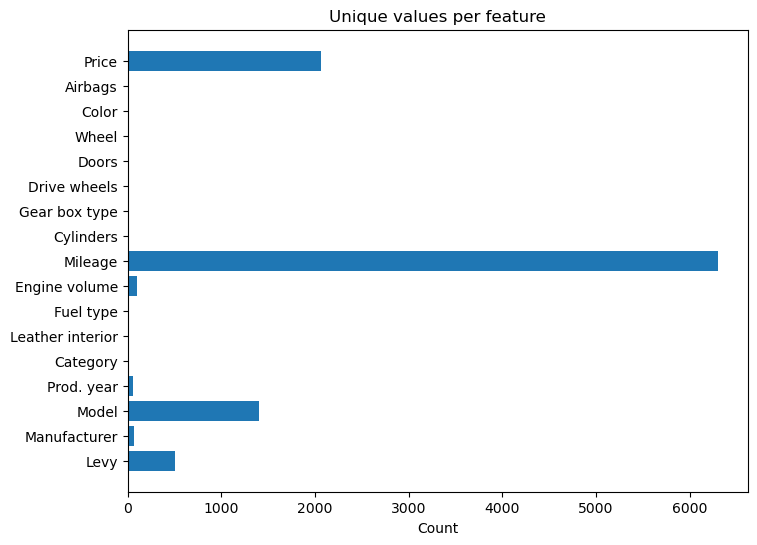

In [166]:
keys, values = [], []

# fill dict with feature uniq values count
for feature in list(data.columns):
    
    nuniq = data[feature].nunique()
    keys.append(feature)
    values.append(nuniq)

    print(f'{feature:<20}: ', nuniq)


# plot unique values count for each feature
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(keys, values)

ax.set_title('Unique values per feature')
ax.set_xlabel('Count')
fig.show()

Nejvíce unikátních hodnot je v příznacích `Mileage`, `Price`, `Model` a `Levy`. Z toho jedinný `Model` budeme považovat za kategorický příznak. Zbylé konvertujeme na numerické hodnoty.

Příznaky s menším počtem unikátních hodnot necháme převážně jako kategorické.

### Otypování kategorických příznaků
Zde si zobrazíme právě unikátní hodnoty příznaků s menším počtem unikátních hodnot.

In [167]:
cat = ['Category', 'Leather interior', 'Fuel type', 
    'Gear box type', 'Drive wheels', 'Doors', 'Wheel'
]

# print unique values for each feature
for feature in cat:
    print(f'{feature}:', list(data[feature].unique()), '\n')

Category: ['Jeep', 'Sedan', 'Minivan', 'Goods wagon', 'Microbus', 'Coupe', 'Hatchback', 'Pickup', 'Universal', 'Cabriolet', 'Limousine'] 

Leather interior: ['No', 'Yes'] 

Fuel type: ['Petrol', 'Diesel', 'CNG', 'Hybrid', 'LPG', 'Plug-in Hybrid', 'Hydrogen'] 

Gear box type: ['Manual', 'Tiptronic', 'Automatic', 'Variator'] 

Drive wheels: ['Front', 'Rear', '4x4'] 

Doors: ['04-May', '>5', '02-Mar'] 

Wheel: ['Left wheel', 'Right-hand drive'] 



Konverze na typ `category`.

In [168]:
data[cat] = data[cat].astype('category')

Pro každý z těchto příznaků ještě kvůli zjištění distribuce hodnot vykreslíme sloupcový graf.

/tmp/ipykernel_2214/2777720729.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_2214/2777720729.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_2214/2777720729.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_2214/2777720729.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_2214/2777720729.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_2214/2777720729.py:11: Us

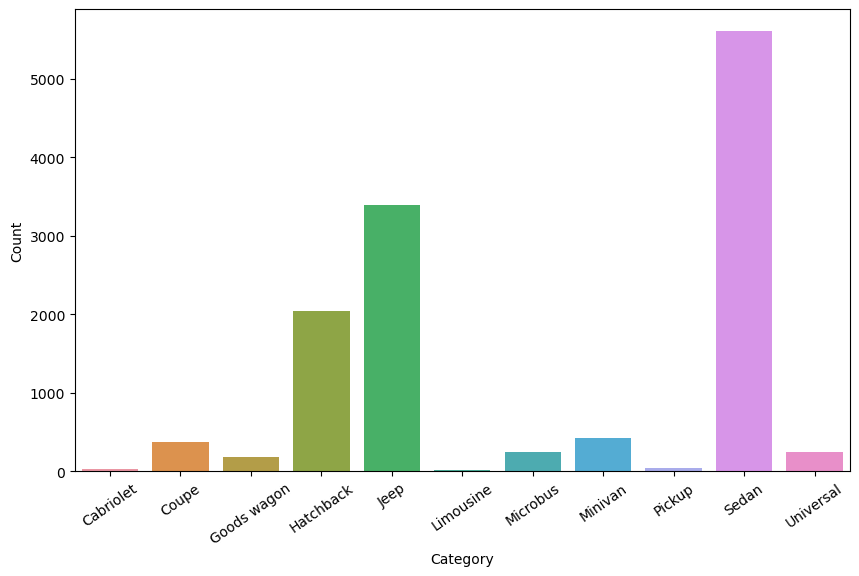

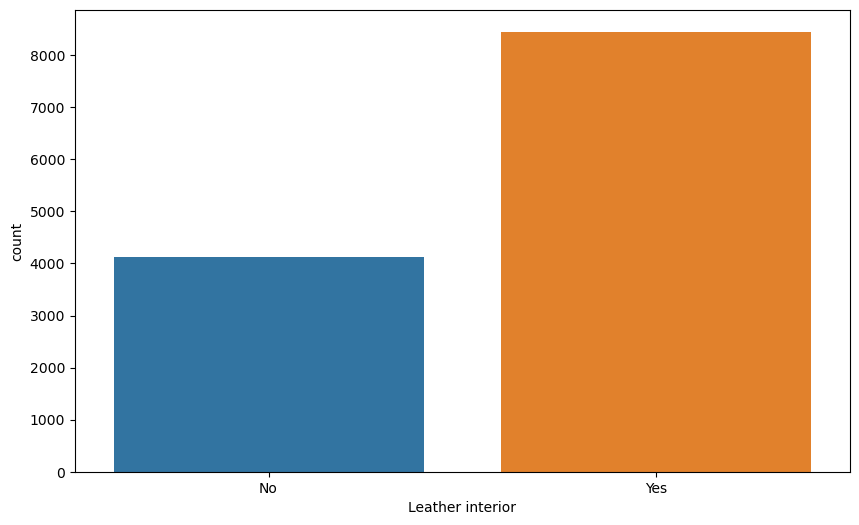

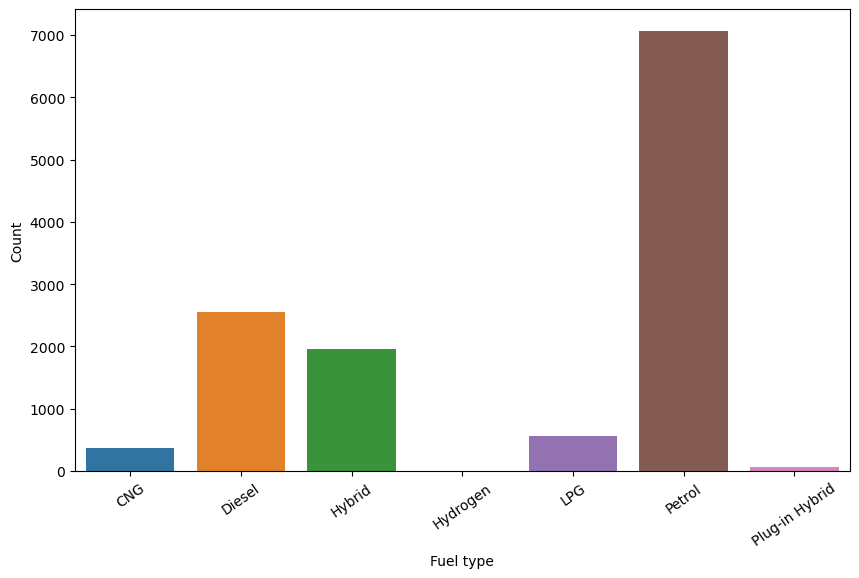

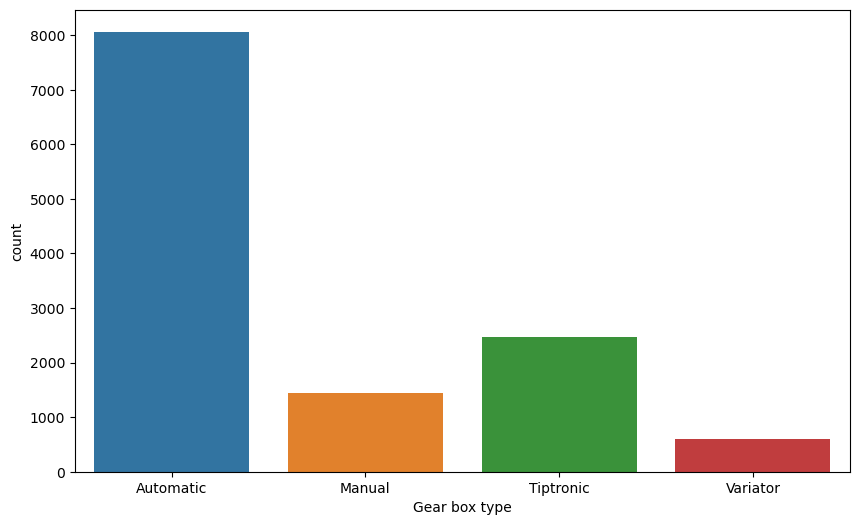

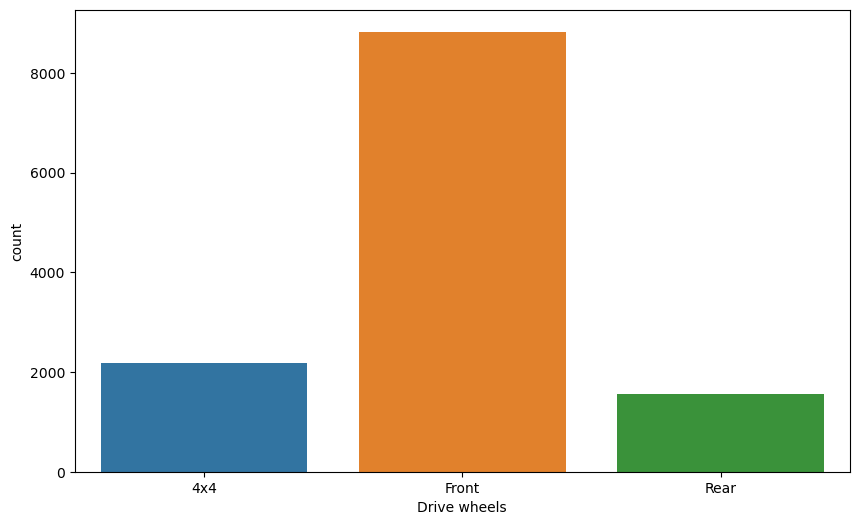

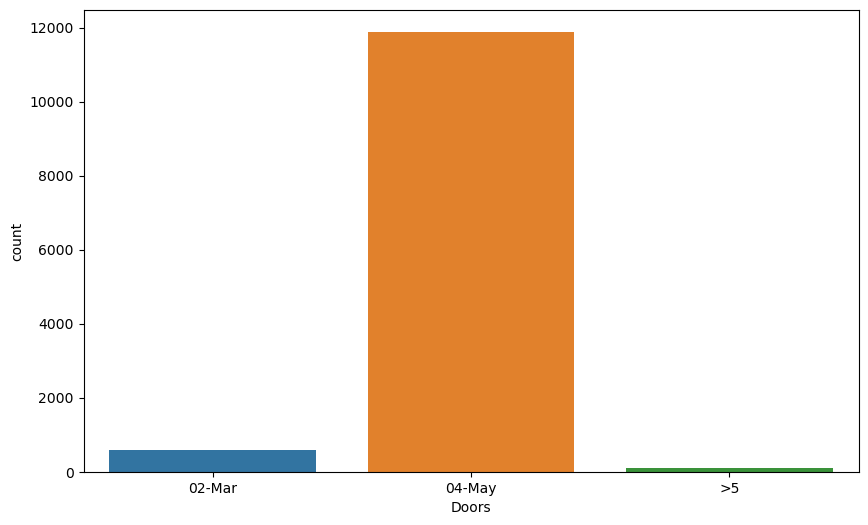

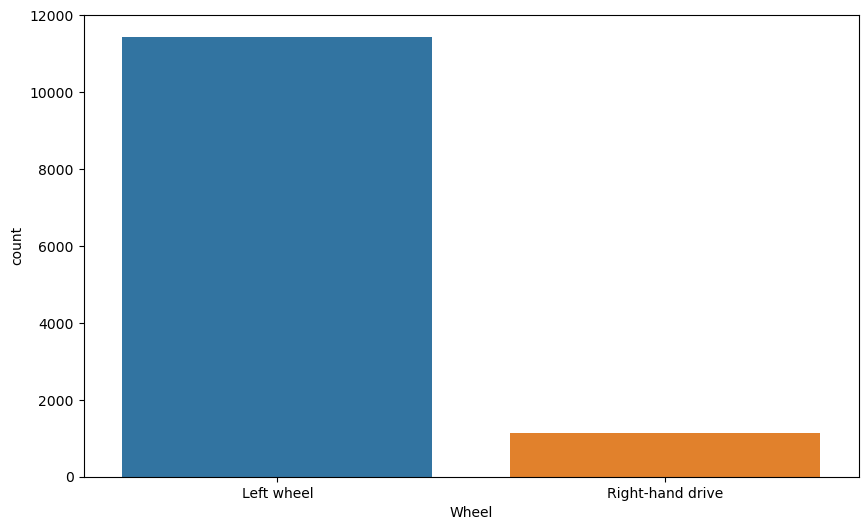

In [169]:
# plot each feature in cat list
for feature in cat:
    fig, ax = plt.subplots(figsize=(10, 6))
    s = sns.countplot(data, x=feature, ax=ax)

    # rotate xticks if more than 6 uniq values
    if data[feature].nunique() > 6:
        s.set_xticklabels(s.get_xticklabels(), rotation=35)
        s.set_ylabel('Count')

    fig.show()

**Poznatky k vizualizacím:**

> Auta mívají spíše kožený iteriér.

> Většina aut jezdí na benzín. O 2. a 3. místo se těsně dělí Nafta a Hybrid.

> Nejčastější je automatická převodovka, přední náhon a 4 dveře. (Není nutně sdílené)

> Většina aut má volant na levé straně.

### Vysvětlovaná proměnná
Naší vysvětlovanou proměnnou je výsledná prodejní cena auta. V této sekci vizualizujeme její distribuci a odlehlé hodnoty.

Distribuční graf spolu s mediánem vysvětlované proměnné.

/tmp/ipykernel_2214/1268421674.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


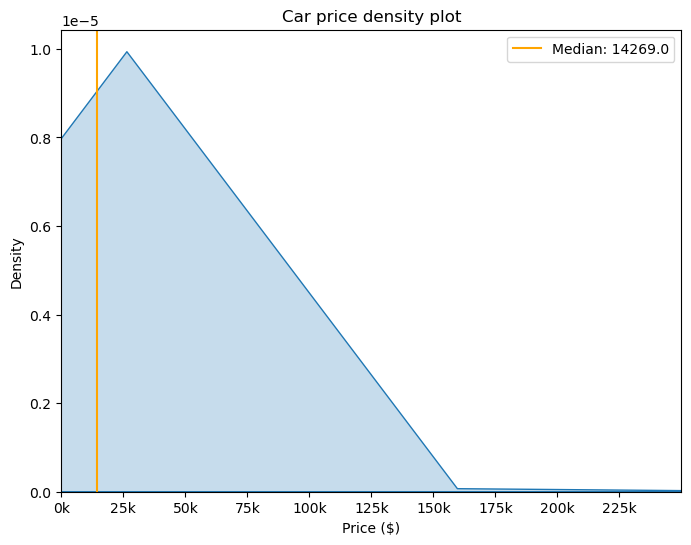

In [170]:
median = pd.Series.median(data[target])

# plot kdeplot
fig, ax = plt.subplots(figsize=(8, 6))

sns.kdeplot(data, x=target, fill=True, ax=ax)

ax.set_xlim(0, 2.5e5)
ax.set_xticks(np.arange(0, 2.5e5, 2.5e4), [f'{x}k' for x in np.arange(0, 226, 25)])
ax.set_title('Car price density plot')
ax.set_xlabel('Price ($)')

# median line
ax.axvline(median, color='orange', label=f'Median: {median}')
ax.legend()

fig.show()

Mediánem je hodnota `$13172`. A cena aut se nejčastěji pohybuje okolo `30k USD`.

Vykreslíme tedy ještě boxplot vysvětlované proměnné.

/tmp/ipykernel_2214/2073283015.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


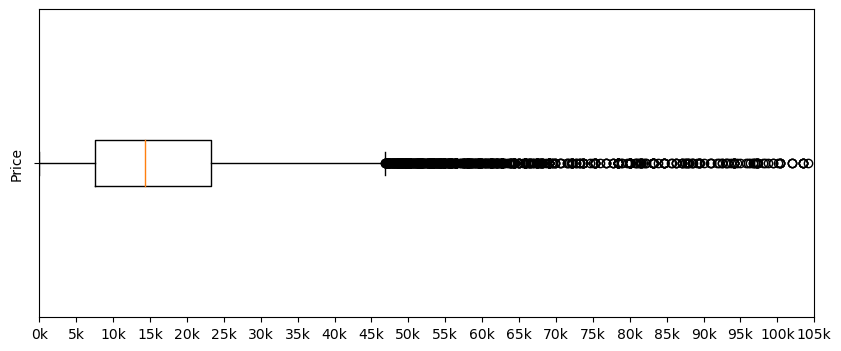

In [171]:
# plot boxplot
fig, ax = plt.subplots(figsize=(10, 4))

ax.boxplot(data[target], vert=False) 
ax.set_xlim((0, 1e5))
ax.set_yticklabels([''])
ax.set_xticks(np.arange(0, 1.1e5, 0.5e4), [str(x) + 'k' for x in np.arange(0, 106, 5)])
ax.set_ylabel('Price')

fig.show()

Můžeme pozorovat, že cena prodaných aut se převážně pohybuje v rozmezí `(5k - 23k) USD`. Od přibližně `47k` a už jde o méně časté prodeje (pravděpodobně luxusnější auta).

### Manufacturer
U příznaku výrobce aut se podíváme na podrobnější závislost na vysvětlované proměnné.

Zobrazíme unikátní hodnoty a přetypujeme na category.

In [172]:
display(data['Manufacturer'].unique())

array(['KIA', 'AUDI', 'BMW', 'VOLKSWAGEN', 'LAND ROVER', 'HYUNDAI',
       'MERCEDES-BENZ', 'FORD', 'TOYOTA', 'MAZDA', 'CHEVROLET', 'NISSAN',
       'HONDA', 'JEEP', 'OPEL', 'DODGE', 'MERCURY', 'UAZ', 'SUBARU',
       'INFINITI', 'GAZ', 'PORSCHE', 'MITSUBISHI', 'RENAULT', 'PEUGEOT',
       'LEXUS', 'FIAT', 'SUZUKI', 'CHRYSLER', 'SSANGYONG', 'VAZ',
       'JAGUAR', 'DAEWOO', 'VOLVO', 'GMC', 'LANCIA', 'DAIHATSU', 'MINI',
       'ISUZU', 'BUICK', 'CADILLAC', 'ACURA', 'SKODA', 'SAAB',
       'ALFA ROMEO', 'MASERATI', 'ZAZ', 'SCION', 'HUMMER', 'PONTIAC',
       'LINCOLN', 'სხვა', 'SEAT', 'CITROEN', 'ASTON MARTIN', 'HAVAL',
       'FERRARI', 'ROVER', 'BENTLEY', 'MOSKVICH', 'GREATWALL',
       'ROLLS-ROYCE', 'LAMBORGHINI'], dtype=object)

In [173]:
data['Manufacturer'] = data['Manufacturer'].astype('category')

Následně si zobrazíme 7 nejčastějších výrobců u prodaných aut.

/tmp/ipykernel_2214/1206689640.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


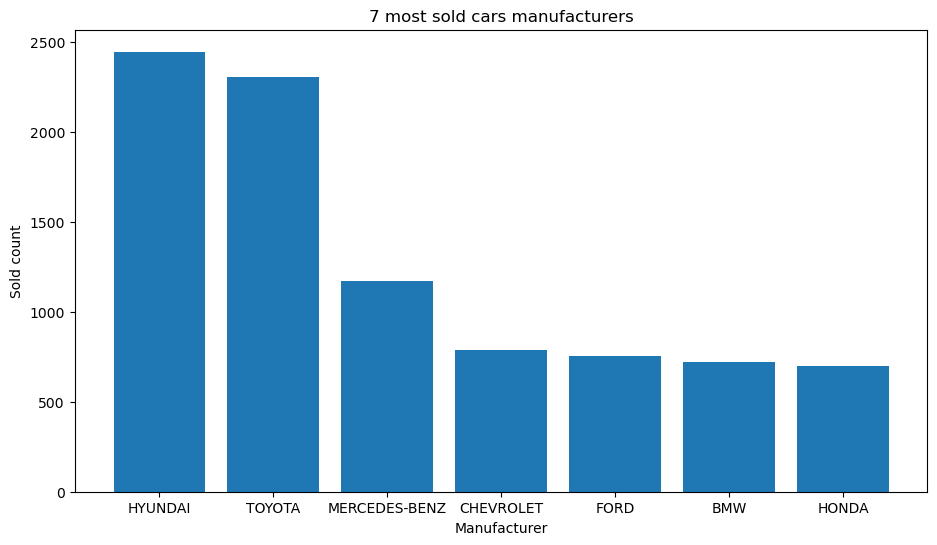

In [174]:
top = 7

# count each unique value
manufacturers = (data['Manufacturer']
    .value_counts()
    .reset_index()
    .sort_values(by='Manufacturer', ascending=False)
)

# plot top manufacturers
keys, values = manufacturers.iloc[:top]['index'], manufacturers.iloc[:top]['Manufacturer']

fig, ax = plt.subplots(figsize=(11, 6))
ax.bar(keys, values)

ax.set_title('7 most sold cars manufacturers')
ax.set_ylabel('Sold count')
ax.set_xlabel('Manufacturer')

fig.show()

Následně zobrazíme nejdražší auta výrobců podle průměru.

/tmp/ipykernel_2214/2237495144.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


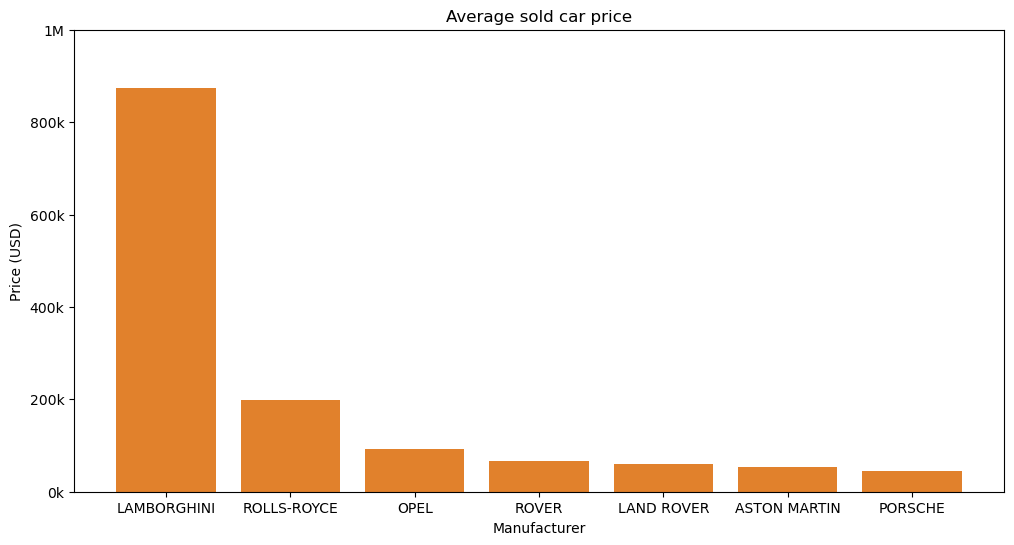

In [175]:
# add mean column into manufacturer df
manufacturers['mean'] = pd.Series([
    data[data['Manufacturer'] == index][target].mean() for index in manufacturers['index']
])

# sort by mean
manufacturers = manufacturers.sort_values(by='mean', ascending=False)

# plot top 7 manufacturers by mean
top = 7
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(list(manufacturers.iloc[:top]['index']), list(manufacturers.iloc[:top]['mean']), color=ORANGE)

ax.set_title('Average sold car price')
ax.set_ylabel('Price (USD)')
ax.set_xlabel('Manufacturer')
ax.set_yticks(np.arange(0, 1000001, 200000), ['0k', '200k', '400k', '600k', '800k', '1M'])

fig.show()

Můžeme pozorovat, že první místo drží jak u četnosti, tak u průměrné nejvyšší ceny **Hyundai**.

### Prod. year
U roku výroby auta si zobrazíme četnost prodejů podle roku a přetypujeme příznak na kategorický typ.

In [176]:
display(data['Prod. year'].unique())

data['Prod. year'] = data['Prod. year'].astype('category')

array([2015, 1998, 2003, 2013, 2012, 2014, 2016, 2010, 1995, 2011, 2005,
       2004, 2000, 2007, 2019, 1997, 2006, 1999, 2017, 2009, 2008, 2002,
       1968, 1993, 1964, 2018, 1994, 2001, 1980, 1996, 2020, 1991, 1988,
       1983, 1986, 1992, 1987, 1989, 1985, 1990, 1977, 1965, 1974, 1953,
       1984, 1982, 1981, 1947, 1976, 1957, 1973, 1939, 1943, 1978])

/tmp/ipykernel_2214/3373189924.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


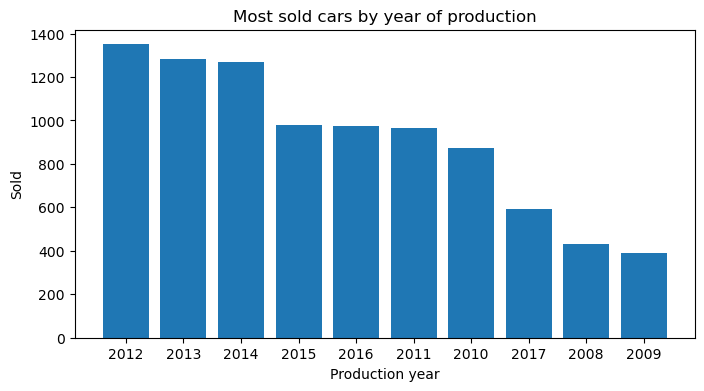

In [177]:
years = (data['Prod. year']
    .value_counts()
    .reset_index()
    .sort_values(by='Prod. year', ascending=False)
)

keys, values = [str(x) for x in years.iloc[:10]['index']], years.iloc[:10]['Prod. year']

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(keys, values)

ax.set_title('Most sold cars by year of production')
ax.set_xlabel('Production year')
ax.set_ylabel('Sold')

fig.show()

### Wheel
U příznaku wheel prozkoumáme závislost mediánu a průměru s cenou auta.

/tmp/ipykernel_2214/3507176129.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


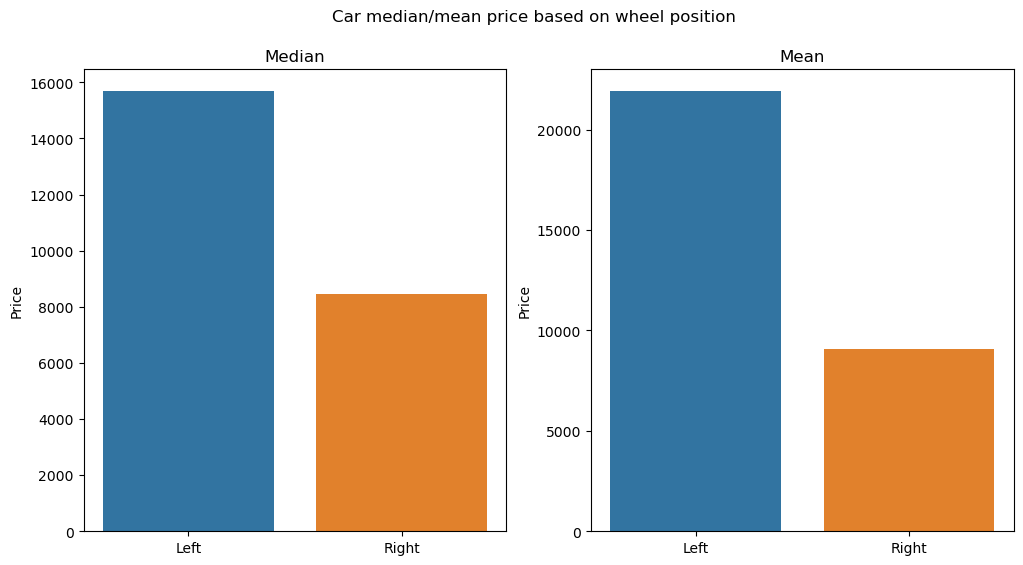

In [178]:
# split data
left_wheel, right_wheel = (
    data[data['Wheel'] == 'Left wheel'][target],
    data[data['Wheel'] == 'Right-hand drive'][target]
)

# get mean and median
left_median, left_mean = left_wheel.median(), left_wheel.mean()
right_median, right_mean = right_wheel.median(), right_wheel.mean()

# plot price based on wheel type
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Car median/mean price based on wheel position')

ax[0].set_title('Median')
ax[0].set_ylabel('Price')
ax[0].bar(['Left', 'Right'], [left_median, right_median], color=[BLUE, ORANGE])

ax[1].set_title('Mean')
ax[1].set_ylabel('Price')
ax[1].bar(['Left', 'Right'], [left_mean, right_mean], color=[BLUE, ORANGE])

fig.show()

### Engine Volume
U příznaku jsme si mohli všimnout, že neobsahuje jen numerické příznaky. Vypíšeme tedy unikátní hodnoty.

In [179]:
display(data['Engine volume'].unique())

array(['1.6', '2.8', '2', '2.5', '3.0 Turbo', '5.0 Turbo', '3', '1.8',
       '2.4', '2.5 Turbo', '2.3', '1.8 Turbo', '1.4', '1.6 Turbo', '1.3',
       '3.2', '5', '4.5', '1.5', '2.2 Turbo', '1.3 Turbo', '2.9 Turbo',
       '4.8', '2.2', '2.0 Turbo', '2.7', '3.5', '1', '1.4 Turbo', '4.7',
       '1.2', '1.5 Turbo', '4', '2.7 Turbo', '3.6', '3.6 Turbo', '3.3',
       '4.6', '3.7', '1.1', '5.7', '3.5 Turbo', '1.7', '1.2 Turbo',
       '6.3 Turbo', '3.8', '2.4 Turbo', '4.4 Turbo', '3.2 Turbo', '0.2',
       '1.9', '5.5', '4.3', '6.2', '4.4', '4.2', '2.9', '2.6', '7.3',
       '4.7 Turbo', '1.9 Turbo', '0.9', '5.3', '0.1', '2.8 Turbo',
       '1.7 Turbo', '0.8', '2.3 Turbo', '0', '5.5 Turbo', '4.6 Turbo',
       '1.0 Turbo', '4.5 Turbo', '0.3 Turbo', '0.7', '5.9', '0.4 Turbo',
       '5.4', '0.7 Turbo', '3.4', '0.6', '2.1', '5.6', '3.9', '0.2 Turbo',
       '6.3', '1.1 Turbo', '0.8 Turbo', '0.4', '6.8', '2.1 Turbo', '5.8',
       '5.7 Turbo', '20', '6.4', '4.8 Turbo', '3.7 Turbo', '0.6 Tur

Některé hodnoty obsahují navíc **Turbo**. Následující funkce tedy vezme dataset a rozdělí tento příznak na 2 různé. Jeden numerický s objemem motoru a druhý binární s informací o turbu. 

In [180]:
def parse_engine_volume(df):
    """ Parse engine volume onto volume and add boolean feature with turbo """

    # add turbo feature
    df['Turbo'] = df['Engine volume'].str.contains('Turbo')

    # remove turbo from engine volume feature
    df['Engine volume'] = df['Engine volume'].apply(lambda x: x[:3]).astype(float)

    return df

data = parse_engine_volume(data)

train = parse_engine_volume(train)
val = parse_engine_volume(val)
test = parse_engine_volume(test)

Ještě vykreslíme poměr aut s turbem a závislost ceny auta na vlastnění turba.

/tmp/ipykernel_2214/3563076048.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


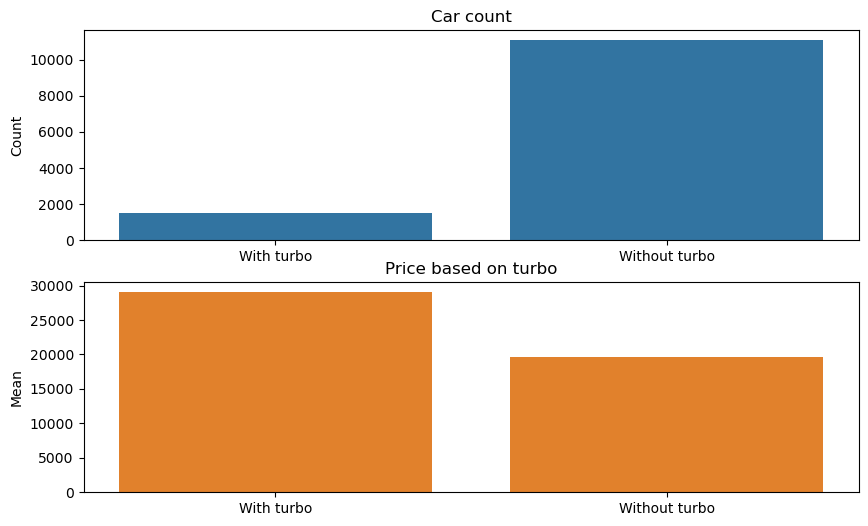

In [181]:
turbo = data['Turbo'].value_counts()

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].bar(['With turbo', 'Without turbo'], [turbo[True], turbo[False]], color=BLUE)
ax[0].set_title('Car count')
ax[0].set_ylabel('Count')

# get turbo means
turbo_mean, no_turbo_mean = (
    data[data['Turbo'] == True]['Price'].mean(), 
    data[data['Turbo'] == False]['Price'].mean()
)

ax[1].bar(['With turbo', 'Without turbo'], [turbo_mean, no_turbo_mean], color=ORANGE)
ax[1].set_title('Price based on turbo')
ax[1].set_ylabel('Mean')

fig.show()

Běžněji se podle vizualizace prodávají auta bez turba a vyšší pruměrnou cenu mají i přesto auta s turbem.

### Levy
Tento příznak by měl určovat výši daně z prodeje v USD.

In [182]:
display(data['Levy'])

17598    629
2493       -
6332       -
4572     779
10762      -
        ... 
16414    595
18666    836
1148       -
14341      -
9107     730
Name: Levy, Length: 12580, dtype: object

Můžeme pozorovat, že příznak obsahuje jak numerické hodnoty, tak znak `-`. Ten bude pravděpodobně značit buď chybějící hodnotu nebo absenci daně.

Proto tento znak nahradíme pomocí `np.nan` v celém datasetu a přetypujeme příznak `Levy` na numerický.

In [183]:
def replace_missing_levy(df):
    """ Replace - with np.nan in Levy feature """

    df.replace(['-'], np.nan, inplace=True)
    df['Levy'] = data['Levy'].astype(float)

    return df

data = replace_missing_levy(data)

Zde vykreslíme distribuci hodnot příznaku a prozkoumáme odlehlé hodnoty po konverzi na numerický typ.

/tmp/ipykernel_2214/3480880195.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


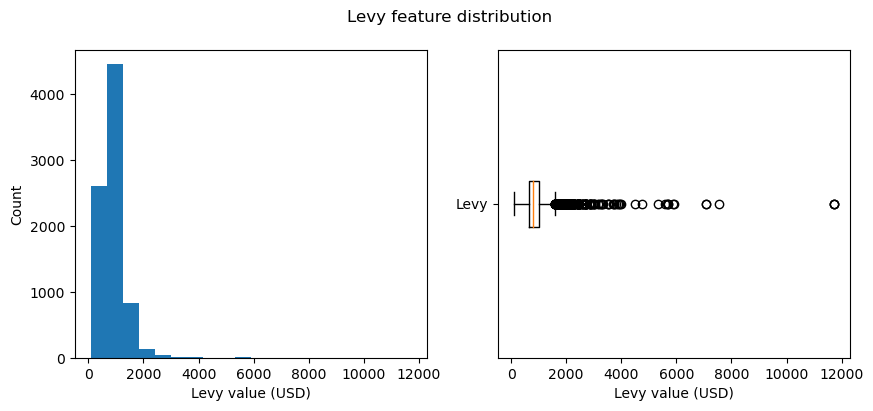

In [184]:
levy = data['Levy'].dropna()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Levy feature distribution')

# hist chart
ax[0].hist(levy, bins=20)
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Levy value (USD)')

# boxplot chart
ax[1].boxplot(levy, vert=False)
ax[1].set_yticks([1], ['Levy'])
ax[1].set_xlabel('Levy value (USD)')

fig.show()

Daň z prodeje se ve většině případech pohybuje od `0 USD` do `2000 USD`. Vyšší daň už je odlehlá hodnota.

### Mileage
Tento příznak budeme muset konvertovat na numerický. Z toho důvodu bude nutné odstranit příponu `km`.

In [185]:
display(data['Mileage'])

17598     85985 km
2493     299689 km
6332          0 km
4572     145600 km
10762    198211 km
           ...    
16414     68000 km
18666    164372 km
1148     450000 km
14341         0 km
9107      74909 km
Name: Mileage, Length: 12580, dtype: object

Následující funkce odstraní z hodnot `km`.

In [186]:
def parse_mileage(df):
    """ Parse mileage feature from given dataset"""

    # remove km string from values
    df['Mileage'] = df['Mileage'].apply(lambda x: int(x.split()[0]))

    return df

data = parse_mileage(data)

train = parse_mileage(train)
val = parse_mileage(val)
test = parse_mileage(test)

Jelikož jde o numerický příznak, tak si opět zobrazíme histogram a boxplot.

Mean: 1_600_568.43
Median: 120_002.50


/tmp/ipykernel_2214/193888250.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


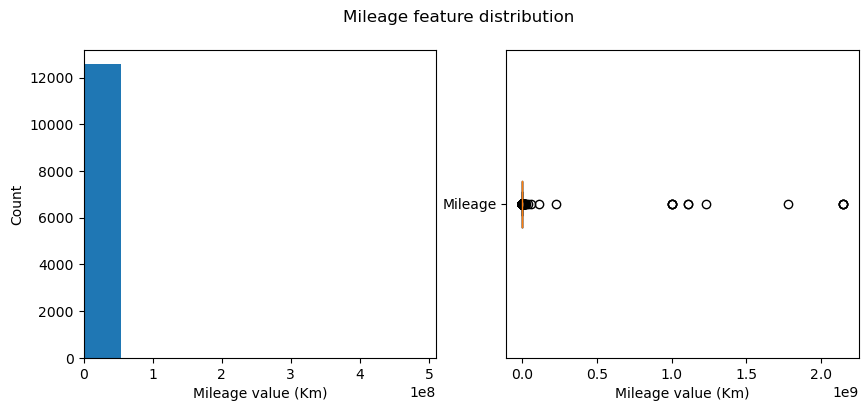

In [187]:
mileage = data['Mileage'].dropna()

print(f'Mean: {mileage.mean():_.2f}')
print(f'Median: {mileage.median():_.2f}')

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Mileage feature distribution')

# hist chart
ax[0].hist(mileage, bins=40)
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Mileage value (Km)')
ax[0].set_xlim(0, 0.51e9)

# boxplot chart
ax[1].boxplot(mileage, vert=False)
ax[1].set_yticks([1], ['Mileage'])
ax[1].set_xlabel('Mileage value (Km)')

fig.show()

Z vizualizace můžeme pozorovat, že nájezd vozidel je velmi nahuštěn v intervalu `(0, 500_000) km`. Dataset taktéž obsahuje odlehlé hodnoty, které by mohly ve výsledku narušovat predikci.

Medián nájezdu je: `120_002 km`.

### Model
Zde si opět zobrazíme unikátní hodnoty.

In [188]:
print('Unique values:', data['Model'].nunique())
display(data['Model'])

Unique values: 1405


17598       SOUL
2493          A6
6332         318
4572      Passat
10762         X5
          ...   
16414       Aqua
18666    Lacetti
1148       E 220
14341       Golf
9107     Elantra
Name: Model, Length: 12580, dtype: object

Příznak model obsahuje obrovské množství unikátních příznaků, ale jeví se spíše jako kategorický. Proto si zobrazíme počet řádků u hodnot, které mají méně jak 5 výskytů.

In [189]:
# get unique value count dataframe
model = (data['Model']
    .value_counts()
    .reset_index()
    .sort_values(by='Model')
    .rename({'Model' : 'Count', 'index' : 'Model'}, axis=1)
)

print(model.shape[0], '->', model.shape[0] - model[model['Count'] < 5].shape[0])

1405 -> 274


Kdybychom tedy nahradili všechny hodnoty s výskytem menším než 5 hodnotou `Other`, tak bychom zredukovali počet unikátních hodnot z `1405` na `274`. 

V rámci `OneHotEncoder` by to mohlo výrazně pomoci s redukcí dimenzionality.

In [190]:
def replace_infrequent_models(df, max_freq, repl):
    """ Replace infrequent models with placeholder """

    # get model values count
    model = df['Model'].value_counts().reset_index().rename({'Model' : 'Count'}, axis=1)

    # get names of infrequent models
    infreq_models = list(model[model['Count'] < max_freq]['index'].unique())

    # replace with placeholder
    df['Model'] = df['Model'].replace(infreq_models, repl)
    return df

data = replace_infrequent_models(data, 5, 'Other')

train = replace_infrequent_models(train, 5, 'Other')
val = replace_infrequent_models(val, 5, 'Other')
test = replace_infrequent_models(test, 5, 'Other')

In [191]:
data['Model'] = data['Model'].astype('category')

### Color
Zde si zobrazíme opět unikátní hodnoty a přetypujeme na typ category.

In [192]:
display(data['Color'].unique())

data['Color'] = data['Color'].astype('category')

array(['Grey', 'Silver', 'Blue', 'White', 'Black', 'Carnelian red',
       'Pink', 'Golden', 'Yellow', 'Green', 'Red', 'Beige', 'Sky blue',
       'Orange', 'Brown', 'Purple'], dtype=object)

Následně vykreslíme barvy aut a jejich četnost v datasetu.

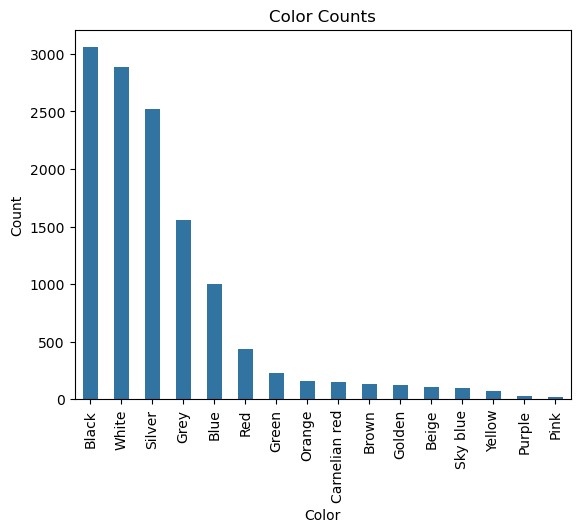

In [193]:
data['Color'].value_counts().plot(kind='bar', color=BLUE)
plt.xlabel('Color')
plt.ylabel('Count')
plt.title('Color Counts')
plt.show()

Nejčastější 3 barvy jsou `černá, bílá a stříbrná`.

### Doors
Příznak obsahující počet dveří má chybné formátování pravděpodobně z důvodu převodu z excel tabulky.
Proto nahradíme `Mar` a `May` odpovídající číselnou hodnotou.

In [194]:
display(data['Doors'].unique())

['04-May', '>5', '02-Mar']
Categories (3, object): ['02-Mar', '04-May', '>5']

Následující funkce nahradí chybné hodnoty číslem.

In [195]:
def fix_door_values(df):
    """ Replace Mar and May with numbers """

    df['Doors'] = (df['Doors']
        .str.replace('Mar', '3', regex=True)
        .str.replace('May', '5', regex=True)
        .str.replace('0', '', regex=True)
        .astype('category')
    )


    return df

data = fix_door_values(data)

train = fix_door_values(train)
val = fix_door_values(val)
test = fix_door_values(test)

### Leather interior
Přetypujeme na číselnou hodnotu.

In [196]:
train['Leather interior'] = train['Leather interior'].map({"Yes":1,'No':0})
val['Leather interior'] = val['Leather interior'].map({"Yes":1,'No':0})
test['Leather interior'] = test['Leather interior'].map({"Yes":1,'No':0})

### Korelace příznaků
Vytvoříme korelační matici pro numerické příznaky a případně ještě vypíšeme příznaky, které mají korelaci větší než `0.3`.

/tmp/ipykernel_2214/3620341371.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data[features].corr()


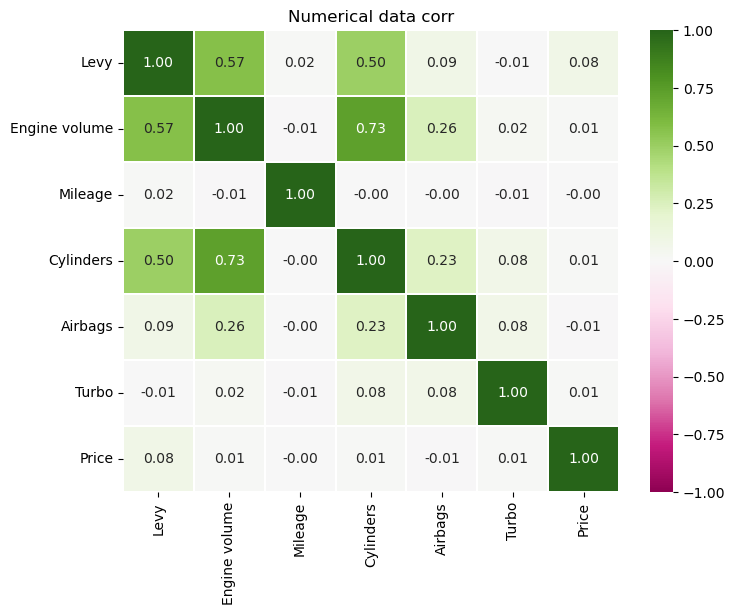

Features with corr coef. higher than |x| > 0.3 that corr. with target:


In [197]:
# get all feature names and put target at the end of list
features = list(data.columns)
features.remove(target)
features.append(target)

# create correlation matrix and select target value coefs
corr = data[features].corr()
coefs = corr[target]

# heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, cmap='PiYG', center=0, vmin=-1, vmax=1, linewidths=.2, annot=True, fmt='.2f')
plt.title('Numerical data corr')
plt.show()

# text correlation with target feature
threshold = 0.3
print(f'Features with corr coef. higher than |x| > {threshold} that corr. with target:')
for feature, coef in zip(corr[:-1], coefs[:-1]):
    if abs(coef) > threshold:
        print(f"{feature.strip(): <35}: {round(coef, 3): < 30}")

**Poznatky:**

> vysvětlovaná proměnná lineárně nekoreluje s žádným příznakem

> Počet válců kladně koreluje s objemem motoru

> Daň z prodeje se zvyšuje s narustajícím počtem válců a objemem motoru

### Chybějící hodnoty
V této sekci analyzujeme chybějící hodnoty v datasetu

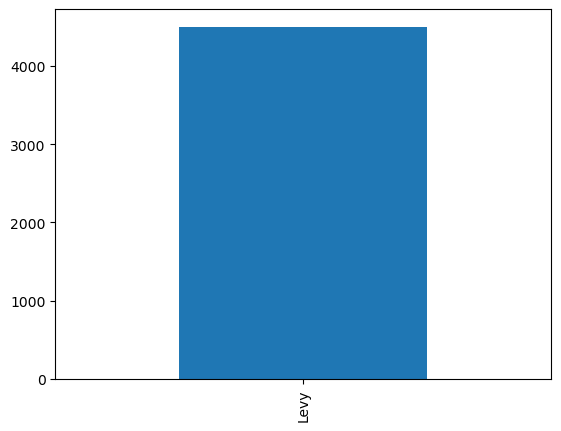

Features with missing values: 1

Missing:
Levy                               : 35.795%


In [198]:
# get null values and sort them
missing = data.isnull().sum()
missing_cnt = data.shape[0]
missing = missing[missing > 0].sort_values()

if len(missing):
    # plot missing values
    missing.plot.bar()
    plt.show()

    print("Features with missing values:", len(missing))

    null_features = []
    for feature in data.columns[data.isnull().any()]:
        null_features.append([feature, data[feature].isnull().sum()])

    null_features.sort(key=lambda x: x[1])

    print("\nMissing:")
    for feature, null_cnt in null_features:
        print(f"{feature.strip(): <35}: {round(null_cnt / (missing_cnt / 100), 3)}%")

Jedinný příznak s chybějícími hodnotami je již zmíněný `Levy`. U něj následně nahradíme chybějící hodnoty nulou.

## Předzpracování dat
V této sekci vytvoříme transformery pro kategorické i numerická data a vyřešíme odlehlé hodnoty.

Rozdělíme data na numerická a kategorická.

In [199]:
cat_features = list(data.select_dtypes('category').columns)
num_features = list(
    set(data._get_numeric_data().columns) 
    - set([target]) 
    - set(['Leather interior'])
)

display(cat_features, num_features)

['Manufacturer',
 'Model',
 'Prod. year',
 'Category',
 'Leather interior',
 'Fuel type',
 'Gear box type',
 'Drive wheels',
 'Doors',
 'Wheel',
 'Color']

['Mileage', 'Turbo', 'Cylinders', 'Engine volume', 'Airbags', 'Levy']

### Nahrazení null hodnot

Nahradíme prázdné hodnoty za `np.nan` pro pozdější snazší zpracování.

In [200]:
def fill_levy(df):
    """ Replace np.nan or '-' in Levy feature with 0 """

    df['Levy'] = df['Levy'].replace([np.nan, '-'], 0).astype(int)
    return df

In [201]:
train = fill_levy(train)
val = fill_levy(val)
test = fill_levy(test)

### Kategorické příznaky

U kategorických příznaků jsme se rozhodli pro jednoduché řešení - `OneHotEncoding`.

In [202]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

print(cat_features)

cat_transformer = Pipeline([
    ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist'))  
])

['Manufacturer', 'Model', 'Prod. year', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color']


### Numerické příznaky

Numerické příznaky standardizujeme.

In [203]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_transformer = Pipeline([
    ('scaler', StandardScaler())
])

### Odlehlé hodnoty

Zbavíme se odlehlých hodnot, čímž ulehčíme práci každému regresnímu modelu a získáme přesnější výsledky.

In [204]:
from scipy import stats
def drop_outliers(data):
    numerical_cols = data.select_dtypes(include=['float', 'int']).columns
    z = np.abs(stats.zscore(data[numerical_cols]))
    outliers = np.concatenate(np.where(z > 3))
    data.drop(data.index[outliers], inplace=True)
    print("Number of rows remaining:", data.shape[0])

In [205]:
drop_outliers(train)
drop_outliers(val)
drop_outliers(test)

Number of rows remaining: 8903
Number of rows remaining: 2942
Number of rows remaining: 2910


## Trénování modelu
V této sekci vyzkoušíme regresní modely a pomocí validačních dat vyladíme hyperparametry.

### Preprocesor
Použijeme předchozí vytvořené transformery pro předzpracování dat.

In [206]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

### Hřebenová regrese
U hřebenové regrese budeme ladit hyperparametr `alpha`, který každému příznaku přidává penalizaci a tím zabraňuje problému kolinearity.

In [207]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import ParameterGrid

Xtrain, ytrain = train.drop([target], axis=1), train[target]
Xval, yval = val.drop([target], axis=1), val[target]

ridge_param_grid = ParameterGrid({
    'alpha' : np.linspace(0.0001, 100, 200),
})

ridge_train_score, ridge_val_score = [], []
for params in ridge_param_grid:

    ridge = Pipeline([
        ('prep', preprocessor),
        ('model', Ridge(**params, random_state=random_state))
    ])

    ridge.fit(Xtrain, ytrain)
    Yth = ridge.predict(Xval)
    
    ridge_train_score.append(ridge.score(Xtrain, ytrain))
    ridge_val_score.append(ridge.score(Xval, yval))

Vykreslíme průběh trénování modelu a přesnost na validačních datech.
Jako zrátová funkce je použita `residual sum of squares`, která je implementovaná v knihovně sklearn.

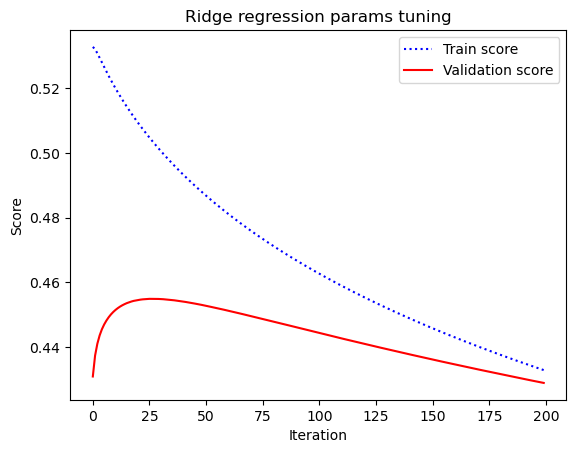

In [208]:
plt.plot(np.arange(len(ridge_train_score)), ridge_train_score, 'b:', label='Train score')
plt.plot(np.arange(len(ridge_val_score)), ridge_val_score, 'r-', label='Validation score')

plt.title('Ridge regression params tuning')
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.legend()
plt.show()

S nejlepšími parametry natrénujeme optimalizovaný model hřebenové regrese a otestujeme metriky přesnosti.

Navíc také vykreslíme regresní přímku mezi daty.

{'alpha': 12.562901507537688}

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Mileage', 'Turbo',
                                                   'Cylinders', 'Engine volume',
                                                   'Airbags', 'Levy']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
                                                  ['Manufacturer', 'Model',
                                                   'Prod. year', 'Category',
                                                   'Leather interior',
                                                   'Fuel type', 'Gear box type',
                                                   'Drive wheels', 'Doors',
                                                   'Wheel', 'Color'])])),
                ('model', Ridge(alpha=12.562901507537688, random_state=420))])

Train score: 0.5047764547929366
Validation score: 0.4549173304234586
RMSE: 10446.150119077969
MAE: 7580.084307452085


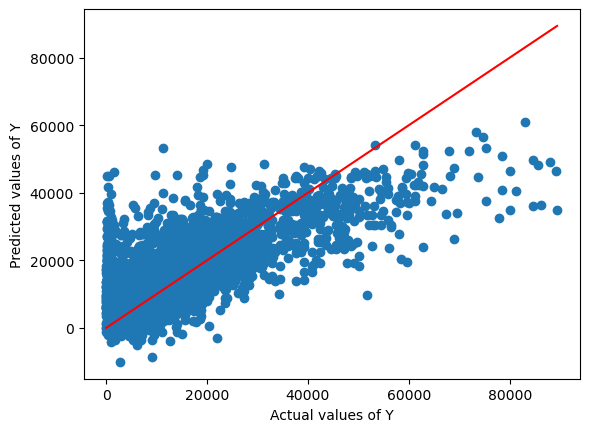

In [209]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# select best ridge params
ridge_best_params = ridge_param_grid[np.argmax(ridge_val_score)]
display(ridge_best_params)

# fit ridge reg. with optimal params
ridge_opt = Pipeline([
    ('prep', preprocessor),
    ('model', Ridge(**ridge_best_params, random_state=random_state))
])

ridge_opt.fit(Xtrain, ytrain)
Yth = ridge_opt.predict(Xval)

# display info
display(ridge_opt)
print('Train score:', ridge_opt.score(Xtrain, ytrain))
print('Validation score:', ridge_opt.score(Xval, yval))
print('RMSE:', mean_squared_error(np.array(yval), ridge_opt.predict(Xval), squared=False))
print('MAE:', mean_absolute_error(np.array(yval), ridge_opt.predict(Xval)))

# plot scatter with reg. line
plt.scatter(yval, Yth)
plt.xlabel('Actual values of Y')
plt.ylabel('Predicted values of Y')
plt.plot((min(yval), max(yval)), (min(yval), max(yval)), 'r-')
plt.show()

### Regresní strom

Dalším modelem je regresní strom, zde porovnáváme výsledky v závislosti na hloubce stromu.

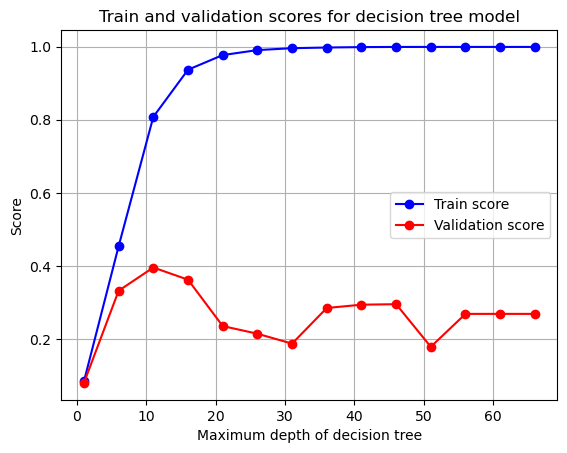

In [210]:
from sklearn.tree import DecisionTreeRegressor

Xtrain, ytrain = train.drop([target], axis=1), train[target]
Xval, yval = val.drop([target], axis=1), val[target]

param_grid = ParameterGrid({
    'max_depth' : np.arange(1, 71, 5),
    # 'max_features' : [35]
})

train_score, val_score = [], []

for params in param_grid:

    reg_tree = Pipeline([
        ('prep', preprocessor),
        ('model', DecisionTreeRegressor(**params, random_state=random_state))
    ])

    reg_tree.fit(Xtrain, ytrain)

    train_score.append(reg_tree.score(Xtrain, ytrain))
    val_score.append(reg_tree.score(Xval, yval))

plt.plot(np.arange(1, 71, 5), train_score, 'bo-', label='Train score')
plt.plot(np.arange(1, 71, 5), val_score, 'ro-', label='Validation score')
plt.xlabel('Maximum depth of decision tree')
plt.ylabel('Score')
plt.title('Train and validation scores for decision tree model')
plt.legend()
plt.grid()
plt.show()

Rozhodli jsme se pro vizualizaci Violionplotem jako zajímavé zobrazení distribuce validačního skóre.

/tmp/ipykernel_2214/864146286.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


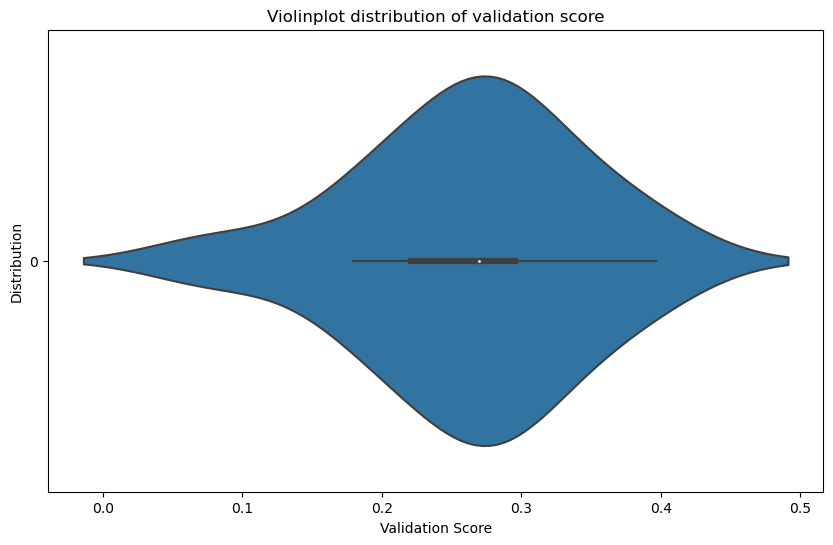

In [211]:
fig, ax = plt.subplots(figsize=(10, 6))
g = sns.violinplot(val_score, orient='h', ax=ax)
g.set_ylabel('Score')
g.set_title('Violinplot distribution of validation score')
ax.set(xlabel='Validation Score', ylabel='Distribution')
fig.show()

### Náhodné lesy

Použijeme model Náhodných lesů a opět ohodnotíme výsledek pomocí RMSE a MAE.

In [212]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
Xtrain, ytrain = train.drop([target], axis=1), train[target]
Xval, yval = val.drop([target], axis=1), val[target]

param_grid = ParameterGrid({
    'n_estimators' : [200],
    'max_depth' : [10]
})

train_score, val_score = [], []

for params in param_grid:

    random_forest = Pipeline([
        ('prep', preprocessor),
        ('model', RandomForestRegressor(**params, random_state=random_state))
    ])

    random_forest.fit(Xtrain, ytrain)
    Yth = random_forest.predict(Xval)

    train_score.append(random_forest.score(Xtrain, ytrain))
    val_score.append(random_forest.score(Xval, yval))

    print('RMSE:', round(mean_squared_error(np.array(yval), Yth, squared=False), 4))
    print('MAE:', round(mean_absolute_error(np.array(yval), Yth), 4))

RMSE: 8666.2751
MAE: 6008.7789


Proložíme predikované body regresní přímkou.

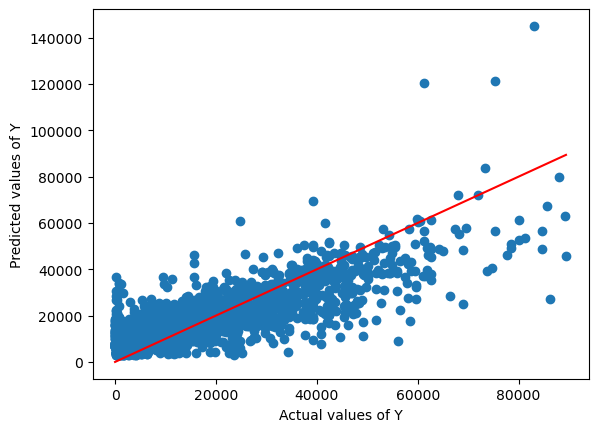

In [213]:
plt.scatter(yval, Yth)
plt.xlabel('Actual values of Y')
plt.ylabel('Predicted values of Y')
plt.plot((min(yval), max(yval)), (min(yval), max(yval)), 'r-')
plt.show()

Můžeme konstatovat, že Náhodné stromy jsou zatím náš nejlepší model!

## Evaluace
Zde aplikujeme identické úpravy na oddělenou testovací část datasetu a otestujeme přesnost našeho modelu.

Nejlepší model nám vyšel Náhodné lesy. A proto tento model opět natrénujeme s optimálnimi parametry a otestujeme ho na testovacích datech.

In [214]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score

Xtrain, ytrain = train.drop([target], axis=1), train[target]
Xtest, ytest = test.drop([target], axis=1), test[target]

random_forest_opt = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestRegressor(n_estimators=200, max_depth=10, random_state=random_state))
])

random_forest_opt.fit(Xtrain, ytrain)
Yth = random_forest_opt.predict(Xtest)

print('Test score:', random_forest_opt.score(Xtest, ytest))
print('Test RMSE:', round(mean_squared_error(np.array(ytest), Yth, squared=False), 4))
print('Test MAE:', round(mean_absolute_error(np.array(ytest), Yth), 4))

Test score: 0.5874970086401439
Test RMSE: 8661.8692
Test MAE: 6001.6821
